In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras.layers import Dropout
from keras.utils import np_utils
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/preprocessed_file_v1_filtered', 
                 compression = "zip", header = 0, index_col = 0, sep = "\t")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1350,1351,1352) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df = df.replace("Unknown", np.nan)
df = df.replace("Not Applicable", np.nan)
df = df.replace("Not Collected", np.nan)
df = df.replace("Not collected", np.nan)
df = df.replace("Not Released", np.nan)

In [5]:
data = df.drop("CANCER_TYPE", axis = 1)
labels = df["CANCER_TYPE"]

In [6]:
for x in data[["SEX", "ETHNICITY", "PRIMARY_RACE", "DEAD"]]:
    data[x], _ = pd.factorize(data[x])

In [7]:
imp = SimpleImputer(missing_values = np.nan, strategy = "constant", fill_value = -1)
data[["YEAR_CONTACT", "YEAR_DEATH"]] = imp.fit_transform(data[["YEAR_CONTACT", "YEAR_DEATH"]])
imp = SimpleImputer(missing_values = '>89', strategy = "constant", fill_value = -1)
data[["YEAR_CONTACT", "YEAR_DEATH"]] = imp.fit_transform(data[["YEAR_CONTACT", "YEAR_DEATH"]])
imp = SimpleImputer(missing_values = '<18', strategy = "constant", fill_value = -1)
data[["YEAR_CONTACT", "YEAR_DEATH"]] = imp.fit_transform(data[["YEAR_CONTACT", "YEAR_DEATH"]])

In [8]:
data = data.astype(int)

In [9]:
data_p = data[["SEX", "ETHNICITY", "PRIMARY_RACE", "DEAD", "YEAR_CONTACT", "YEAR_DEATH"]]

In [10]:
print(labels.unique(), len(labels.unique()))

['Glioma' 'Leukemia' 'Thyroid Cancer' 'Hepatobiliary Cancer'
 'Mature B-Cell Neoplasms' 'Non-Small Cell Lung Cancer'
 'Soft Tissue Sarcoma' 'Pancreatic Cancer' 'Head and Neck Cancer'
 'Esophagogastric Cancer' 'Melanoma' 'Breast Cancer' 'Endometrial Cancer'
 'Colorectal Cancer' 'Prostate Cancer' 'Renal Cell Carcinoma'
 'Bladder Cancer' 'Ovarian Cancer'] 18


In [11]:
encoder = preprocessing.LabelEncoder()
classes = encoder.fit_transform(labels)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
									data_p, classes, 
									test_size = 0.2, 
									random_state = 0) 

print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)

(78067,)
(78067, 6)
(19517,)
(19517, 6)


In [13]:
learning_rate = 0.1
opt = 'ADAM'
size_batch = 128
nb_epochs = 50

In [14]:
#11th try: removed genomic data and reduced network size

model = Sequential()	
	
model.add(	
	Dense(6, input_dim = x_train.shape[1], activation = 'relu'))

model.add(	
	Dense(12, activation = 'relu'))
	
model.add(	
	Dense(len(labels.unique()), activation = 'softmax'))
	
model.compile(optimizer = opt,	
						loss = 'sparse_categorical_crossentropy',	
						metrics = ["accuracy"])	

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 18)                234       
                                                                 
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________


In [16]:
es = EarlyStopping(
  monitor = 'val_accuracy', mode = 'max', 
	verbose = 1, patience = 30)

In [17]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_d = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [18]:
history = model.fit(
	x_train, y_train, 
	validation_data = (x_test, y_test), 
	batch_size = size_batch, 
  epochs = nb_epochs, 
  class_weight = class_weights_d,
	verbose = 1, callbacks = [es])

Epoch 1/50
610/610 [==============================] - 2s 2ms/step - loss: 33.9050 - accuracy: 0.0644 - val_loss: 3.2181 - val_accuracy: 0.0547
Epoch 2/50
610/610 [==============================] - 1s 2ms/step - loss: 2.9050 - accuracy: 0.0754 - val_loss: 2.8135 - val_accuracy: 0.0522
Epoch 3/50
610/610 [==============================] - 1s 2ms/step - loss: 2.7799 - accuracy: 0.0599 - val_loss: 2.7887 - val_accuracy: 0.0642
Epoch 4/50
610/610 [==============================] - 1s 2ms/step - loss: 2.7669 - accuracy: 0.0616 - val_loss: 2.7983 - val_accuracy: 0.0550
Epoch 5/50
610/610 [==============================] - 1s 2ms/step - loss: 2.7679 - accuracy: 0.0604 - val_loss: 2.7838 - val_accuracy: 0.0534
Epoch 6/50
610/610 [==============================] - 1s 2ms/step - loss: 2.7591 - accuracy: 0.0621 - val_loss: 2.8076 - val_accuracy: 0.0666
Epoch 7/50
610/610 [==============================] - 1s 2ms/step - loss: 2.7538 - accuracy: 0.0627 - val_loss: 2.7848 - val_accuracy: 0.0525
Epoch

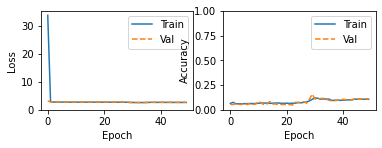

In [19]:
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(history.epoch, history.history[metric],  label='Train')
  plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  elif metric == 'auc':
    plt.ylim([0.8,1])
  else:
    plt.ylim([0,1])

  plt.legend()

